In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    sys.path.append(module_path)

In [8]:
import numpy as np
import pandas as pd
import trackpy as tp
import seaborn as sns
import matplotlib.pyplot as plt

from cmcrameri import cm
from scipy.stats import linregress

from scipy.ndimage import gaussian_filter

# from src.Segmentation3D import *
# from src.CellSegmentation import *
# from src.HolomonitorFunctions import *
from src.Correlations import temporal_correlation

n0 = 1.33
nd = 1.4

In [94]:
min_len    = 4     # hours
diff_lim   = 0.5 
median_lim = 0.5

In [95]:
# TOMOCUBE
file = "A2P1"
folder = "../../data/Tomocube/MDCK_10.02.2025/"
search_range = 50
dt = 4

# # HOLOMONITOR
# folder = "../../data/Holomonitor/MDCK_19.03.2024/"
# file = "B1-11"
# search_range = 10dt = 4
# dt = 12

In [96]:

# tracks cells
df    = pd.read_csv(f"{folder}{file}/area_volume_filtered.csv")
tracks_raw = tp.link(df, search_range=search_range, memory=5)
tracks = tp.filter_stubs(tracks_raw, 5)
tracks = tracks.reset_index(drop=True)

Frame 39: 989 trajectories present.


In [97]:
# sort on lenght
particles = []
track_len = []

for p in range(max(tracks.particle)):
    particles.append(p)
    track_len.append(sum(tracks.particle==p))

particles = np.array(particles)
track_len = np.array(track_len)

# list of particles with tracks longer than min_len
long_tracks = particles[track_len >= min_len*dt]



# sort out dividing cells and segmentation errors
good_tracks = []
h_cell = []
A_cell = []
V_cell = []
n_cell = []
t_cell = []

for p in long_tracks:
    cell_mask = (tracks.particle == p)

    # remove outlier data points
    dist_from_median = abs(tracks[cell_mask].V - np.median(tracks[cell_mask].V)) / np.median(tracks[cell_mask].V)
    not_outlier = (dist_from_median <= median_lim)

    # difference between consecutive frames
    dA = abs(np.diff(tracks[cell_mask][not_outlier].A)      / (tracks[cell_mask][not_outlier].A[1:]))
    dh = abs(np.diff(tracks[cell_mask][not_outlier].h_avrg) / (tracks[cell_mask][not_outlier].h_avrg[1:]))
    good_mask = (dA.values <= diff_lim)*(dh.values <= diff_lim)

    # add if difference is never more than diff_lim and not too many outliers
    if np.sum(good_mask) == len(good_mask) and sum(not_outlier) >= min_len:
        good_tracks.append(p)

        V_cell.append(tracks[cell_mask][not_outlier].V.values)
        A_cell.append(tracks[cell_mask][not_outlier].A.values)
        h_cell.append(tracks[cell_mask][not_outlier].h_avrg.values)
        n_cell.append(tracks[cell_mask][not_outlier].n_avrg.values)
        t_cell.append(tracks[cell_mask][not_outlier].frame.values / dt)

print(len(good_tracks))

579


In [98]:
def get_fluctuations(t_arr, arr):
    fit = linregress(t_arr, arr)
    lin_fit = fit.intercept + t_arr*fit.slope
    return np.std(arr-lin_fit) / np.mean(arr)

V_fluct = []
A_fluct = []
h_fluct = []
n_fluct = []
v_fluct = []

for i in range(len(V_cell)):
    V_fluct.append(get_fluctuations(t_cell[i], V_cell[i])*100)
    A_fluct.append(get_fluctuations(t_cell[i], A_cell[i])*100)
    h_fluct.append(get_fluctuations(t_cell[i], h_cell[i])*100)
    n_fluct.append(get_fluctuations(t_cell[i], n_cell[i])*100)

    #V_fluct.append(np.std(v_cell[i]) / np.mean(v_cell[i]))
    #A_fluct.append(np.std(a_cell[i]) / np.mean(a_cell[i]))
    #h_fluct.append(np.std(h_cell[i]) / np.mean(h_cell[i]))
    #n_fluct.append(np.std(n_cell[i]) / 1.38)

    v = (np.array(n_cell[i])-n0) / (nd-n0)
    v_fluct.append(100*np.std(v) / np.mean(v))


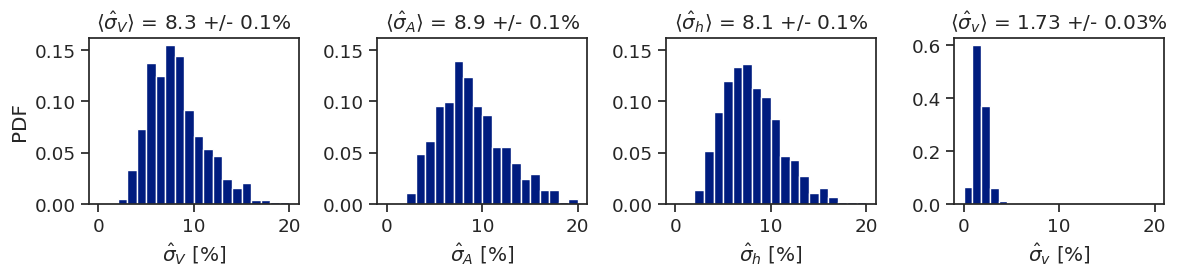

In [99]:
bins = 20
hist_range = [0,20]

fig = plt.figure(figsize=(12,3))
sns.set_theme(style='ticks', palette='dark', font_scale=1.2)

ax0 = fig.add_subplot(1, 4, 1)
ax1 = fig.add_subplot(1, 4, 2, sharey = ax0)
ax2 = fig.add_subplot(1, 4, 3, sharey = ax0)
ax3 = fig.add_subplot(1, 4, 4)

ax0.hist(V_fluct, density="True", bins=bins, range=hist_range)
ax1.hist(A_fluct, density="True", bins=bins, range=hist_range)
ax2.hist(h_fluct, density="True", bins=bins, range=hist_range)
ax3.hist(v_fluct, density="True", bins=bins+2, range=hist_range)

ax0.set(title=rf"$\langle \hat{{\sigma}}_V \rangle$ = {np.mean(V_fluct):0.1f} +/- {np.std(V_fluct) / np.sqrt(len(V_fluct)):0.1f}%", xlabel=r"$\hat{\sigma}_V$ [%]")
ax1.set(title=rf"$\langle \hat{{\sigma}}_A \rangle$ = {np.mean(A_fluct):0.1f} +/- {np.std(A_fluct) / np.sqrt(len(V_fluct)):0.1f}%", xlabel=r"$\hat{\sigma}_A$ [%]")
ax2.set(title=rf"$\langle \hat{{\sigma}}_h \rangle$ = {np.mean(h_fluct):0.1f} +/- {np.std(h_fluct) / np.sqrt(len(V_fluct)):0.1f}%", xlabel=r"$\hat{\sigma}_h$ [%]")
ax3.set(title=rf"$\langle \hat{{\sigma}}_v \rangle$ = {np.mean(v_fluct):0.2f} +/- {np.std(v_fluct) / np.sqrt(len(V_fluct)):0.2f}%", xlabel=r"$\hat{\sigma}_v$ [%]")
ax0.set(ylabel="PDF")

fig.tight_layout()
#fig.savefig("../../figs/volume/relative_error.png", dpi=300)

In [92]:
# compute correlation
def correlation_from_errorprop(sV, sA, sh):
    '''
    Estimate correlation based on propagation of uncertainty (approximation)
    sX: relative uncertainty on variable X
    '''
    return (sV**2 - sA**2 - sh**2) / (2*sA*sh)


def correlation(t_arr, x_arr, y_arr):
    '''
    Calculate correlation of fluctuations explicitly from values of variables.
    '''
    rho = 0
    for t, x, y in zip(t_arr, x_arr, y_arr):
        fit = linregress(t, x)
        lin_fit = fit.intercept + t*fit.slope
        x = x - lin_fit

        fit = linregress(t, y)
        lin_fit = fit.intercept + t*fit.slope
        y = y - lin_fit

        rho += np.corrcoef(np.array(x), np.array(y))[0,1]

    return rho / len(x_arr)


def errorprop(x, y, rho_xy):
    return np.sqrt(np.mean(x)**2 + np.mean(y)**2 + 2*np.mean(x)*np.mean(y)*rho_xy)


In [93]:
# compute correlation between h and A
print(rf"rho_hA from error propagation: {correlation_from_errorprop(np.mean(V_fluct), np.mean(A_fluct), np.mean(h_fluct)):0.2f}")
print(rf"rho_hA from ensemble average:  {correlation(t_cell, h_cell, A_cell):0.2f}")

rho_hA from error propagation: -0.31
rho_hA from ensemble average:  -0.33


In [62]:
v_cell  = [(n-n0)/(nd-n0) for n in n_cell]
Vd_cell = [v*V for v, V in zip(v_cell, V_cell)]

rho_vV  = correlation(t_cell, v_cell, V_cell)
rho_VdV = correlation(t_cell, Vd_cell, V_cell)

print(rf"rho_vV  from ensemble average: {rho_vV:0.2f}")
print(rf"rho_VdV from ensemble average: {rho_VdV:0.2f}")


sVd = np.sqrt(np.mean(V_fluct)**2 + (1.38/(1.38-1.33))**2*np.mean(n_fluct)**2 + 2*np.mean(V_fluct)*np.mean(n_fluct)*(1.38/(1.38-1.33))*rho_vV)
print(f"Fluctuations in V_d: {sVd:0.2f}")

rho_vV  from ensemble average: 0.35
rho_VdV from ensemble average: 0.99
Fluctuations in V_d: 8.89


In [13]:
# find characteristic time
max_frame = np.max(tracks.frame)+1
C_vv = np.zeros(max_frame)
C_aa = np.zeros(max_frame)
C_hh = np.zeros(max_frame)
C_av = np.zeros(max_frame)
C_ah = np.zeros(max_frame)
C_hv = np.zeros(max_frame)


for t, v, a, h in zip(t_cell, V_cell, A_cell, h_cell):
    fit = linregress(t, v)
    lin_fit = fit.intercept + t*fit.slope
    v = v - lin_fit

    fit = linregress(t, a)
    lin_fit = fit.intercept + t*fit.slope
    a = a - lin_fit

    fit = linregress(t, h)
    lin_fit = fit.intercept + t*fit.slope
    h = h - lin_fit

    C_vv[:len(t)] += temporal_correlation(v, v)
    C_aa[:len(t)] += temporal_correlation(a, a)
    C_hh[:len(t)] += temporal_correlation(h, h)

    C_av[:len(t)] += temporal_correlation(a,v)
    C_ah[:len(t)] += temporal_correlation(a,h)
    C_hv[:len(t)] += temporal_correlation(h,v)

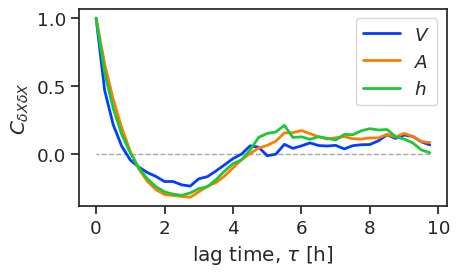

In [16]:
corr_v = C_vv / C_vv[0]
corr_a = C_aa / C_aa[0]
corr_h = C_hh / C_hh[0]
time = np.arange(max_frame) / 4

fig, ax = plt.subplots(1,1, figsize=(5,3))
sns.set_theme(style='ticks', palette='bright', font_scale=1.2)
ax.hlines(0, time.max(), 0, linestyle="dashed", color="gray", alpha=0.7, lw=1)

ax.plot(time, corr_v, '-', lw=2, label=r"$V$")
ax.plot(time, corr_a, '-', lw=2, label=r"$A$")
ax.plot(time, corr_h, '-', lw=2, label=r"$h$")

ax.set(xlabel=r"lag time, $\tau$ [h]", ylabel=r"$C_{\delta X \delta X}$")
ax.legend()

fig.tight_layout( rect=[-0.05, 0, 0.97, 1.0])
#fig.savefig("../../figs/autocorrelation/cellwise_autocorrelation.png", dpi=300)

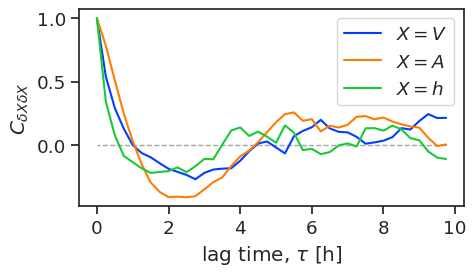

In [15]:
corr_av = C_av / C_av[0]#(std_a * std_v)
corr_ah = C_ah / C_ah[0]#(std_a * std_h)
corr_hv = C_hv / C_hv[0]#(std_h * std_v)
time = np.arange(max_frame) / 4

fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.hlines(0, time.max(), 0, linestyle="dashed", color="gray", alpha=0.7, lw=1)

ax.plot(time, corr_av, label=r"$X=V$")
ax.plot(time, corr_ah, label=r"$X=A$")
ax.plot(time, corr_hv, label=r"$X=h$")


ax.set(xlabel=r"lag time, $\tau$ [h]", ylabel=r"$C_{\delta X \delta X}$")
ax.legend()
fig.tight_layout()
#fig.savefig("../../figs/autocorrelation/cellwise_crosscorrelation.png")

In [64]:
np.sqrt(np.mean(A_fluct)**2 + np.mean(h_fluct)**2) # 0.9

12.02797813179752

1.9320000000000004